### Edge Detection Techniques
#### Theory
Edge detection is a fundamental task in image processing and computer vision. It involves identifying significant transitions in intensity within an image, which often correspond to object boundaries, textures, or other structural information. This lab explores three popular edge detection techniques: Sobel, Prewitt, and Canny edge detectors. Each method has its unique approach to detecting edges, and understanding their differences is crucial for selecting the appropriate technique for specific applications.
#### 1. Sobel Operator
The Sobel operator is a discrete differentiation operator used to compute an approximation of the gradient of the image intensity function. It uses two 3x3 convolution kernels, one for detecting changes in the horizontal direction (Gx) and the other for the vertical direction (Gy). The gradient magnitude is computed as:
\[
G = \sqrt{G_x^2 + G_y^2}
\]
The Sobel operator emphasizes edges in the vertical and horizontal directions, making it robust to noise.
#### 2. Prewitt Operator
The Prewitt operator is similar to the Sobel operator but uses a different set of convolution kernels. It is a simpler method for edge detection and is less computationally intensive. The kernels for the Prewitt operator are designed to detect horizontal and vertical edges. The gradient magnitude is calculated in the same way as the Sobel operator.
#### 3. Canny Edge Detector
The Canny edge detector is a multi-step algorithm that provides robust edge detection. It involves the following steps:
1. **Gaussian Blurring**: Smooth the image to reduce noise.
2. **Gradient Calculation**: Compute the intensity gradient using Sobel-like operators.
3. **Non-Maximum Suppression**: Thin the edges by suppressing non-maximum gradient values.
4. **Double Thresholding**: Classify edges as strong, weak, or non-edges based on gradient magnitude.
5. **Edge Tracking by Hysteresis**: Connect weak edges to strong edges if they are part of the same boundary.
#### Objectives
1. Understand the mathematical principles behind Sobel, Prewitt, and Canny edge detection methods.
2. Implement these techniques manually to gain deeper insights into their workings.
3. Compare the results of the three methods on a sample image.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
def manual_convolution(image, kernel):
    img_height, img_width = image.shape
    kernel_height, kernel_width = kernel.shape
    pad = kernel_height // 2

    output = np.zeros_like(image, dtype=np.float64)
    padded_image = np.pad(image, pad)

    for i in range(img_height):
        for j in range(img_width):
            region = padded_image[i : i + kernel_height, j : j + kernel_width]
            output[i, j] = np.sum(region * kernel)
    return output


def manual_sobel(image):

    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    gradient_x = manual_convolution(image, sobel_x)
    gradient_y = manual_convolution(image, sobel_y)

    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    gradient_magnitude = gradient_magnitude * 255.0 / np.max(gradient_magnitude)

    return gradient_magnitude.astype(np.uint8)


def manual_prewitt(image):
    prewitt_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    prewitt_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])

    gradient_x = manual_convolution(image, prewitt_x)
    gradient_y = manual_convolution(image, prewitt_y)

    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    gradient_magnitude = gradient_magnitude * 255.0 / np.max(gradient_magnitude)

    return gradient_magnitude.astype(np.uint8)


def manual_gaussian_blur(image, kernel_size=5, sigma=1.0):
    k = kernel_size // 2
    x, y = np.mgrid[-k : k + 1, -k : k + 1]
    kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    kernel = kernel / kernel.sum()
    return manual_convolution(image, kernel)


def manual_canny(image, low_threshold=50, high_threshold=150):
    blurred = manual_gaussian_blur(image)

    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    gradient_x = manual_convolution(blurred, sobel_x)
    gradient_y = manual_convolution(blurred, sobel_y)

    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    gradient_direction = np.arctan2(gradient_y, gradient_x) * 180 / np.pi

    gradient_magnitude = gradient_magnitude * 255.0 / np.max(gradient_magnitude)
    gradient_magnitude = gradient_magnitude.astype(np.uint8)

    height, width = gradient_magnitude.shape
    suppressed = np.zeros_like(gradient_magnitude)

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            angle = gradient_direction[i, j]
            if angle < 0:
                angle += 180

            if (0 <= angle < 22.5) or (157.5 <= angle <= 180):
                if (
                    gradient_magnitude[i, j] >= gradient_magnitude[i, j - 1]
                    and gradient_magnitude[i, j] >= gradient_magnitude[i, j + 1]
                ):
                    suppressed[i, j] = gradient_magnitude[i, j]
            elif 22.5 <= angle < 67.5:
                if (
                    gradient_magnitude[i, j] >= gradient_magnitude[i - 1, j + 1]
                    and gradient_magnitude[i, j] >= gradient_magnitude[i + 1, j - 1]
                ):
                    suppressed[i, j] = gradient_magnitude[i, j]
            elif 67.5 <= angle < 112.5:
                if (
                    gradient_magnitude[i, j] >= gradient_magnitude[i - 1, j]
                    and gradient_magnitude[i, j] >= gradient_magnitude[i + 1, j]
                ):
                    suppressed[i, j] = gradient_magnitude[i, j]
            else:
                if (
                    gradient_magnitude[i, j] >= gradient_magnitude[i - 1, j - 1]
                    and gradient_magnitude[i, j] >= gradient_magnitude[i + 1, j + 1]
                ):
                    suppressed[i, j] = gradient_magnitude[i, j]

    result = np.zeros_like(suppressed)

    strong_edges = suppressed >= high_threshold
    weak_edges = (suppressed >= low_threshold) & (suppressed < high_threshold)

    result[strong_edges] = 255

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            if weak_edges[i, j]:
                if result[i - 1 : i + 2, j - 1 : j + 2].max() == 255:
                    result[i, j] = 255
    return result

In [3]:
image = cv2.imread("stdimgs/peppers.png", cv2.IMREAD_GRAYSCALE)
sobel_edges = manual_sobel(image)
prewitt_edges = manual_prewitt(image)
canny_edges = manual_canny(image)

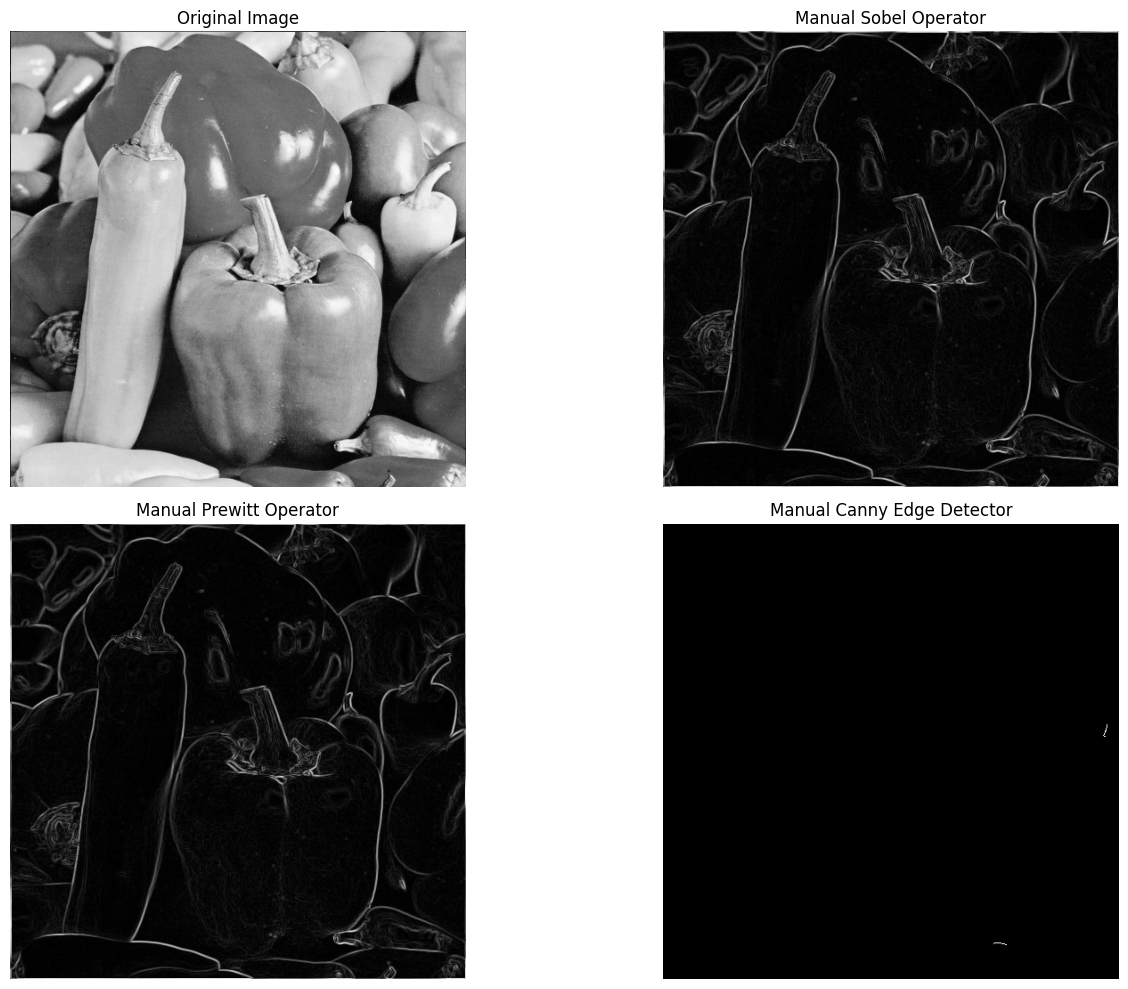

In [4]:

titles = ["Original Image", "Manual Sobel Operator", "Manual Prewitt Operator", "Manual Canny Edge Detector"]
images = [image, sobel_edges, prewitt_edges, canny_edges]

plt.figure(figsize=(15, 10))
for i, (title, img) in enumerate(zip(titles, images), start=1):
	plt.subplot(2, 2, i)
	plt.title(title)
	plt.imshow(img, cmap="gray")
	plt.axis("off")
plt.tight_layout()